# Get Instance Mask from Flows

In [1]:
import os
import torch
import numpy as np

from skimage import io
from skimage.morphology import label, binary_dilation, binary_closing, ball
from skimage.measure import regionprops
from scipy.ndimage import gaussian_filter

def print_timestamp(msg):
    print(msg)
    
def calculate_flows(instance_mask, bg_label=0):
    
    flow_x = np.zeros(instance_mask.shape, dtype=np.float32)
    flow_y = np.zeros(instance_mask.shape, dtype=np.float32)
    flow_z = np.zeros(instance_mask.shape, dtype=np.float32)
    regions = regionprops(instance_mask)
    for props in regions:
        
        if props.label == bg_label:
            continue
        
        c = props.centroid
        coords = np.where(instance_mask==props.label)
        
        flow_x[coords] = np.tanh((coords[0]-c[0])/5)
        flow_y[coords] = np.tanh((coords[1]-c[1])/5)
        flow_z[coords] = np.tanh((coords[2]-c[2])/5)
    
    return flow_x, flow_y, flow_z

def cellpose_flowcontrol(fg_map, flow_x, flow_y, flow_z, niter=100, njobs=4,\
                         min_diameter=10, max_diameter=100, step_size=1, smoothing_var=1, fg_thresh=0.5,\
                         fg_overlap_thresh=0.5, flow_thresh=0.5, save_path=None, normalize_flows=True,\
                         verbose=True, convexity_thresh=0.1, invert_flows=False):
    
    fg_map = fg_map.astype(np.float32)
    flow_x = flow_x.astype(np.float32)
    flow_y = flow_y.astype(np.float32)
    flow_z = flow_z.astype(np.float32)
    
    # Normalize flow maps
    if normalize_flows:
        if verbose: print_timestamp('Normalizing the flow fields...')
        max_flow = np.max(np.abs(np.array((flow_x,flow_y,flow_z))))
        flow_x /= max_flow
        flow_y /= max_flow
        flow_z /= max_flow    
        
    if invert_flows:
        if verbose: print_timestamp('Inverting the flow fields...')
        flow_x *= -1
        flow_y *= -1
        flow_z *= -1        
    
    # Smooth the flow fields
    if smoothing_var>0:
        if verbose: print_timestamp('Smoothing the flow fields...')
        flow_x = gaussian_filter(flow_x, smoothing_var).astype(np.float32)
        flow_y = gaussian_filter(flow_y, smoothing_var).astype(np.float32)
        flow_z = gaussian_filter(flow_z, smoothing_var).astype(np.float32)
        
    # Prepare flow arrays
    flow_x_torch = torch.from_numpy(flow_x*step_size)
    flow_y_torch = torch.from_numpy(flow_y*step_size)
    flow_z_torch = torch.from_numpy(flow_z*step_size)
    
    if verbose: print_timestamp('Initializing positions...')      
    # Initialize each position
    pos_x, pos_y, pos_z = np.indices(fg_map.shape, dtype=np.float32)
    pos_x = torch.from_numpy(pos_x)
    pos_y = torch.from_numpy(pos_y)
    pos_z = torch.from_numpy(pos_z)
        
    # Iteratively move each pixel along the flow field   
    for i in range(niter):
        
        if verbose: print(f'\r Iteration {i+1}/{niter}', end="")
        
        # Get updated position
        new_x = torch.clamp(pos_x - flow_x_torch[(pos_x.long(), pos_y.long(), pos_z.long())], 0, fg_map.shape[0]-1)
        new_y = torch.clamp(pos_y - flow_y_torch[(pos_x.long(), pos_y.long(), pos_z.long())], 0, fg_map.shape[1]-1)
        new_z = torch.clamp(pos_z - flow_z_torch[(pos_x.long(), pos_y.long(), pos_z.long())], 0, fg_map.shape[2]-1)
        
        # Assign new positions
        pos_x = new_x
        pos_y = new_y
        pos_z = new_z        
                                
    # Convert tensor to numpy
    pos_x = pos_x.data.numpy().astype(np.uint16)
    pos_y = pos_y.data.numpy().astype(np.uint16)
    pos_z = pos_z.data.numpy().astype(np.uint16)
    
    # Create map of final positions
    pos_mask = np.zeros_like(fg_map, dtype=bool)
    pos_mask[pos_x,pos_y,pos_z] = True
        
    # Reconstruct each clustered instance
    if verbose: print_timestamp('Reconstructing instances...')
    pos_mask = binary_closing(pos_mask, footprint=ball(min_diameter//2))# try replacing selem with footprint
    pos_mask = label(pos_mask)
    instances = pos_mask[(pos_x, pos_y, pos_z)]
    
    # Remove noise and huge instance clusters
    fg_map = binary_dilation(fg_map>fg_thresh, ball(min_diameter//2))
    if verbose: print_timestamp('Removing oversized instance clusters and noise...')
    labels, counts = np.unique(instances, return_counts=True)
    remove_labels = [l for l,c in zip(labels, counts) if c<4/3*np.pi*(min_diameter/2)**3 or c>4/3*np.pi*(max_diameter/2)**3 or np.sum(fg_map[instances==l])/c<fg_overlap_thresh]    
    if len(remove_labels)>0:
        if verbose: print('Labels removed due to Overlap', len(remove_labels))
        instances[np.isin(instances, remove_labels)] = 0
    
    # Remove bad flow masks
    if verbose: print_timestamp('Removing instances with bad flow and bad convexity...')
    recon_flow_x, recon_flow_y, recon_flow_z = calculate_flows(instances)
    flow_error = (np.abs(flow_x-recon_flow_x) + np.abs(flow_y-recon_flow_y) + np.abs(flow_z-recon_flow_z))/3
    remove_labels = []
    error_map = np.zeros_like(instances, dtype=np.float32)
    for region in regionprops(instances):
        error_map[instances==region.label] = np.mean(flow_error[instances==region.label])
        if np.mean(flow_error[instances==region.label]) > flow_thresh:
            remove_labels.append(region.label)
            if verbose: print('Label removed due to flow_thresh', region.label)
        if region.minor_axis_length/region.major_axis_length < convexity_thresh:
            remove_labels.append(region.label)
            if verbose: print('Label removed due to convexity_thresh', region.label)
    if len(remove_labels)>0:
            instances[np.isin(instances, remove_labels)] = 0
        
    # Adjust final label range
    if verbose: print_timestamp('Adjusting final label range...')
    instances = label(instances)
    instances = instances.astype(np.uint32)

    if not save_path is None:
        if verbose: print_timestamp('Saving results...')
        io.imsave(save_path, instances)
    
    if verbose: print_timestamp('Finished!')
        
    return instances

C:\Users\admin\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_patch(img, patch_shape, x_start, y_start, z_start):
    '''random tile strategy'''
    x_end = x_start + patch_shape[0]
    y_end = y_start + patch_shape[1]
    z_end = z_start + patch_shape[2]
    return img[x_start:x_end, y_start:y_end, z_start:z_end, :]

def patch(img, patch_shape):
    patches = []
    
    num_x = img.shape[0] // patch_shape[0]
    num_y = img.shape[1] // patch_shape[1]
    num_z = img.shape[2] // patch_shape[2]
    
    for x in range(num_x):
        for y in range(num_y):
            for z in range(num_z):
            
                x_start = patch_shape[0] * x
                y_start = patch_shape[1] * y
                z_start = patch_shape[2] * z

                patch = get_patch(img, patch_shape, x_start, y_start, z_start)
                patches.append(patch)
    
    return np.array(patches)

def re_patch(patches, img_shape):
    patch_shape = patches.shape[1:]
    img = np.zeros(img_shape)
    num_x = img_shape[0] // patch_shape[0]
    num_y = img_shape[1] // patch_shape[1]
    num_z = img_shape[2] // patch_shape[2]
    
    current_patch = 0
    for x in range(num_x):
        for y in range(num_y):
            for z in range(num_z):
                x_start = patch_shape[0] * x
                y_start = patch_shape[1] * y
                z_start = patch_shape[2] * z
                x_end = x_start + patch_shape[0]
                y_end = y_start + patch_shape[1]
                z_end = z_start + patch_shape[2]
                img[x_start:x_end, y_start:y_end, z_start:z_end, :] = patches[current_patch]
                
                current_patch = current_patch+1
    return img

In [ ]:
from unet3d import UNet3D
import numpy as np
import tensorflow as tf
MODEL_NAME = 'Cellpose3D-Semantic'# or Cellpose3D
FEAT_CHANNELS = 16
BATCH_SIZE=16

model = UNet3D(feat_channels=FEAT_CHANNELS)
model.build((None, 256,256,256,5)) # or (64,64,64,1)
model.load_weights(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5')

img = np.load('data/images/leaf3.npy')# or data_no_semantic/
print(img.shape)
patches = patch(img, (64,64,64,5))# or (64,64,64,1)
print(patches.shape)

pred = np.zeros((*patches.shape[:-1], 4))
batch_start = 0
while batch_start < patches.shape[0]:
    batch = patches[batch_start:batch_start+BATCH_SIZE]
    print(batch_start, batch.shape)
    pred[batch_start:batch_start+BATCH_SIZE] = model(batch)
    batch_start +=BATCH_SIZE

recon_img = re_patch(pred, (256,256,256,4))
np.save('pred_semantic.npy', recon_img)

In [ ]:
recon_img =  np.load('pred-cellpose3d.npy')
fg_map = recon_img[:,:,:,0]
flow_x = recon_img[:,:,:,1]
flow_y = recon_img[:,:,:,2]
flow_z = recon_img[:,:,:,3]
#print(recon_img[:,:,:,1:].min(), recon_img[:,:,:,1:].max())
#print(recon_img[:,:,:,0].min(), recon_img[:,:,:,1].max())

instances = cellpose_flowcontrol(fg_map, flow_x, flow_y, flow_z, min_diameter=10, fg_overlap_thresh=0.2, verbose=False)# if min dia is too small we throw errors 
#tested min_dia in {4,6,8,10,12,14} and fg_overlap_thresh in {0.2,0.3,0.4,0.5}

from matplotlib import pyplot as plt
plt.imshow(instances[:,:,-10])
plt.show()

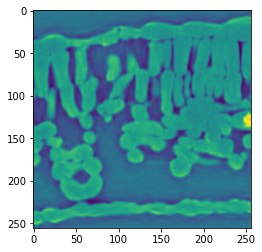

In [92]:
from matplotlib import pyplot as plt
img = np.load('data_no_semantic/images/leaf3.npy')
plt.imshow(img[:,:,-10])
plt.show()
# orig_sl58 = [58,:,:]
# orig_sl128 = [128,:,:]
# orig_sl164 = [164,:,:]
# orig_sl169 = [:,169,:]
# orig_sl248 = [:,248,:]
# orig_sl10 = [:,:,-10]
# orig_sl103 = [:,:,-103]



# Evaluate Instance Masks

$AP= \sum_{k=1}^n P(k) \Delta r(k)$

$P$: precision, $r$:recall and $k$ is probably the iou threshold, $\Delta r(k)$ is the change in recall from recall $r(k-1)$ to $r(k)$

In [ ]:
# Works correctly but is far too slow
import numpy as np
from skimage.measure import regionprops
from skimage import io

def get_iou(gt_coords, pred_coords):
    n_intersect = 0
    for gt_coord in gt_coords:
        for pred_coord in pred_coords:
            if np.all(pred_coord==gt_coord):
                n_intersect+=1
    n_union = gt_coords.shape[0] + pred_coords.shape[0] - n_intersect
    return n_intersect / n_union


gt_instances = io.imread('ground_truth/human_sl10.png').astype(np.uint32)
pred_instances = gt_instances +1000 #instances[:,:,-10]

def pre_rec_th(gt_instances, pred_instances, iou_th):
    tp=0
    fn=0
    fp=0

    gt_props = regionprops(gt_instances)
    pred_props = regionprops(pred_instances)
    n_gt = set(range(len(gt_props)))
    n_pred = set(range(len(pred_props)))

    for i_gt in n_gt:
        max_iou=0
        match_i_pred = -1
        for i_pred in n_pred:
            iou = get_iou(gt_props[i_gt].coords, pred_props[i_pred].coords)
            if iou > max_iou:
                max_iou = iou
                match_i_pred = i_pred
        if max_iou > iou_th:
            # found match => remove from set to prevent double matvch
            n_pred.remove(match_i_pred)
            # n_gt.remove(i_gt) => each is looked at only once so we do not have to prevent duplicates
            tp+=1
        else:
            # for the gt region no pred region exists => predicted as negative, even though it is positve =>fn
            fn+=1
        print(f'{i_gt} von {len(n_gt)} \r', end="")

    # alle pred die übrig sind müssten damit fp sein
    fp = len(n_pred)
    
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    return pre, rec

p,r = pre_rec_th(gt_instances, pred_instances, 0.5)

def get_ap(gt_instances, pred_instances):
    iou_ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
    ap = 0
    old_rec = 0
    for iou_th in iou_ths:
        pre, rec = pre_rec_th(gt_instances, pred_instances, iou_th)
        print('precision and recall @th:', pre, rec, iou_th)
        delta_rec = rec-old_rec
        ap = ap + pre * delta_rec
        old_rec = rec
    return ap

# Evaluate Instance Masks with external code

In [6]:
import glob
import logging
import os
import sys

import h5py
import argparse
import numpy as np
import scipy.ndimage
from scipy.optimize import linear_sum_assignment
from skimage.segmentation import relabel_sequential


class Metrics:
    def __init__(self):
        self.metricsDict = {}
        self.metricsArray = []


    def addTable(self, name, dct=None):
        levels = name.split(".")
        if dct is None:
            dct = self.metricsDict
        if levels[0] not in dct:
            dct[levels[0]] = {}
        if len(levels) > 1:
            name = ".".join(levels[1:])
            self.addTable(name, dct[levels[0]])

    def getTable(self, name, dct=None):
        levels = name.split(".")
        if dct is None:
            dct = self.metricsDict
        if len(levels) == 1:
            return dct[levels[0]]
        else:
            name = ".".join(levels[1:])
            return self.getTable(name, dct=dct[levels[0]])

    def addMetric(self, table, name, value):
        self.metricsArray.append(value)
        tbl = self.getTable(table)
        tbl[name] = value


def maybe_crop(pred_labels, gt_labels, overlapping_inst=False):
    if overlapping_inst:
        if gt_labels.shape[1:] == pred_labels.shape[1:]:
            return pred_labels, gt_labels
        else:
            # todo: add other cases
            raise NotImplementedError("Sorry, cropping for overlapping "
                                      "instances not implemented yet!")
    else:
        if gt_labels.shape == pred_labels.shape:
            return pred_labels, gt_labels
        if gt_labels.shape[0] > pred_labels.shape[0]:
            bigger_arr = gt_labels
            smaller_arr = pred_labels
            swapped = False
        else:
            bigger_arr = pred_labels
            smaller_arr = gt_labels
            swapped = True
        begin = (np.array(bigger_arr.shape) -
                 np.array(smaller_arr.shape)) // 2
        end = np.array(bigger_arr.shape) - begin
        if len(bigger_arr.shape) == 2:
            bigger_arr = bigger_arr[begin[0]:end[0],
                                    begin[1]:end[1]]
        else:
            if (np.array(bigger_arr.shape) -
                np.array(smaller_arr.shape))[2] % 2 == 1:
                end[2] -= 1
            bigger_arr = bigger_arr[begin[0]:end[0],
                                    begin[1]:end[1],
                                    begin[2]:end[2]]
        if not swapped:
            gt_labels = bigger_arr
            pred_labels = smaller_arr
        else:
            pred_labels = bigger_arr
            gt_labels = smaller_arr

        return pred_labels, gt_labels

def evaluate_file(pred_labels, gt_labels, background=0,
                  foreground_only=False, use_linear_sum_assignment=True):
   
    
    pred_labels = np.squeeze(pred_labels)

    if gt_labels.shape[0] == 1:
        gt_labels.shape = gt_labels.shape[1:]
    gt_labels = np.squeeze(gt_labels)
    if gt_labels.ndim > pred_labels.ndim:
        gt_labels = np.max(gt_labels, axis=0)

    # pred_labels = pred_1instpch

    # heads up: should not crop channel dimensions, assuming channels first
    overlapping_inst = False
    pred_labels, gt_labels = maybe_crop(pred_labels, gt_labels,
                                        overlapping_inst)

    if foreground_only:
        pred_labels[gt_labels==0] = 0

    # relabel gt labels in case of binary mask per channel
    if overlapping_inst and np.max(gt_labels) == 1:
        for i in range(gt_labels.shape[0]):
            gt_labels[i] = gt_labels[i] * (i + 1)

    if use_linear_sum_assignment:
        return evaluate_linear_sum_assignment(gt_labels, pred_labels,
                                             overlapping_inst=False, filterSz=None,
                                             visualize=False)

    # get gt cell ids and the size of the corresponding cell
    gt_labels_list, gt_counts = np.unique(gt_labels, return_counts=True)
    gt_labels_count_dict = {}
    for (l, c) in zip(gt_labels_list, gt_counts):
        gt_labels_count_dict[l] = c

    # get pred cell ids
    pred_labels_list, pred_counts = np.unique(pred_labels,
                                              return_counts=True)
    pred_labels_count_dict = {}
    for (l, c) in zip(pred_labels_list, pred_counts):
        pred_labels_count_dict[l] = c

    # get overlapping labels
    if overlapping_inst:
        pred_tile = [1,] * pred_labels.ndim
        pred_tile[0] = gt_labels.shape[0]
        gt_tile = [1,] * gt_labels.ndim
        gt_tile[1] = pred_labels.shape[0]
        pred_tiled = np.tile(pred_labels, pred_tile).flatten()
        gt_tiled = np.tile(gt_labels, gt_tile).flatten()
        mask = np.logical_or(pred_tiled > 0, gt_tiled > 0)
        overlay = np.array([
            pred_tiled[mask],
            gt_tiled[mask]
        ])
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)
    else:
        overlay = np.array([pred_labels.flatten(),
                            gt_labels.flatten()])
        # get overlaying cells and the size of the overlap
        overlay_labels, overlay_labels_counts = np.unique(overlay,
                                             return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)

    # identify overlaying cells where more than 50% of gt cell is covered
    matchesSEG = np.asarray([c > 0.5 * float(gt_counts[gt_labels_list == v])
        for (u,v), c in zip(overlay_labels, overlay_labels_counts)],
                            dtype=np.bool)

    # get their ids
    matches_labels = overlay_labels[matchesSEG]

    # remove background
    if background is not None:
        pred_labels_list = pred_labels_list[pred_labels_list != background]
        gt_labels_list = gt_labels_list[gt_labels_list != background]

    matches_mat = np.zeros((len(pred_labels_list), len(gt_labels_list)))
    for (u, v) in matches_labels:
        if u > 0 and v > 0:
            matches_mat[np.where(pred_labels_list == u),
                        np.where(gt_labels_list == v)] = 1

    diceGT = {}
    iouGT = {}
    segGT = {}
    diceP = {}
    iouP = {}
    segP = {}
    segPrev = {}
    for (u,v), c in zip(overlay_labels, overlay_labels_counts):
        dice = 2.0 * c / (gt_labels_count_dict[v] + pred_labels_count_dict[u])
        iou = c / (gt_labels_count_dict[v] + pred_labels_count_dict[u] - c)

        if c > 0.5 * gt_labels_count_dict[v]:
            seg = iou
        else:
            seg = 0
        if c > 0.5 * pred_labels_count_dict[u]:
            seg2 = iou
        else:
            seg2 = 0

        if v not in diceGT:
            diceGT[v] = []
            iouGT[v] = []
            segGT[v] = []
        if u not in diceP:
            diceP[u] = []
            iouP[u] = []
            segP[u] = []
            segPrev[u] = []
        diceGT[v].append(dice)
        iouGT[v].append(iou)
        segGT[v].append(seg)
        diceP[u].append(dice)
        iouP[u].append(iou)
        segP[u].append(seg)
        segPrev[u].append(seg2)

    if background is not None:
        iouP.pop(background)
        iouGT.pop(background)
        diceP.pop(background)
        diceGT.pop(background)
        segP.pop(background)
        segPrev.pop(background)
        segGT.pop(background)

    dice = 0
    cnt = 0
    for (k, vs) in diceGT.items():
        vs = sorted(vs, reverse=True)
        dice += vs[0]
        cnt += 1
    diceGT = dice/max(1, cnt)

    dice = 0
    cnt = 0
    for (k, vs) in diceP.items():
        vs = sorted(vs, reverse=True)
        dice += vs[0]
        cnt += 1
    diceP = dice/max(1, cnt)

    iou = []
    instances = gt_labels.copy().astype(np.float32)
    for (k, vs) in iouGT.items():
        vs = sorted(vs, reverse=True)
        iou.append(vs[0])
        instances[instances==k] = vs[0]
    iouGT = np.array(iou)
    iouGTMn = np.mean(iouGT)

    iou = []
    iouIDs = []
    instances = pred_labels.copy().astype(np.float32)
    for (k, vs) in iouP.items():
        vs = sorted(vs, reverse=True)
        iou.append(vs[0])
        iouP[k] = vs
        iouIDs.append(k)
        instances[instances==k] = vs[0]

    iouP_2 = np.array(iou)
    iouIDs = np.array(iouIDs)
    iouPMn = np.mean(iouP_2)

    seg = 0
    cnt = 0
    for (k, vs) in segGT.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segGT = seg/max(1, cnt)

    seg = 0
    cnt = 0
    for (k, vs) in segP.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segP = seg/max(1, cnt)

    seg = 0
    cnt = 0
    for (k, vs) in segPrev.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segPrev = seg/max(1, cnt)

    # non-split vertices num non-empty cols - num non-empty rows
    # (more than one entry in col: predicted cell with more than one
    # ground truth cell assigned)
    # (other way around not possible due to 50% rule)
    ns = np.sum(np.count_nonzero(matches_mat, axis=0)) \
            - np.sum(np.count_nonzero(matches_mat, axis=1) > 0)
    ns = int(ns)

    # false negative: empty cols
    # (no predicted cell for ground truth cell)
    fn = np.sum(np.sum(matches_mat, axis=0) == 0)
    fn = int(fn)

    # false positive: empty rows
    # (predicted cell for non existing ground truth cell)
    fp = np.sum(np.sum(matches_mat, axis=1) == 0)
    fp = int(fp)

    # true positive: row with single entry (can be 0, 1, or more)
    tpP = np.sum(np.sum(matches_mat, axis=1) == 1)
    tpP = int(tpP)

    # true positive: non-empty col (can only be 0 or 1)
    tpGT = np.sum(np.sum(matches_mat, axis=0) > 0)
    tpGT = int(tpGT)


    metrics = Metrics()
    tblNameGen = "general"
    metrics.addTable(tblNameGen)
    metrics.addMetric(tblNameGen, "Num GT", len(gt_labels_list))
    metrics.addMetric(tblNameGen, "Num Pred", len(pred_labels_list))
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean dice", diceGT)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean dice", diceP)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean iou", iouGTMn)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean iou", iouPMn)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean seg", segGT)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean seg", segP)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean seg rev", segPrev)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref NS", ns)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref FP", fp)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref TP", tpP)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred FN", fn)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred TP", tpGT)

    ths = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    metrics.addTable("confusion_matrix")
    for th in ths:
        tblname = "confusion_matrix.th_"+str(th).replace(".","_")
        metrics.addTable(tblname)
        apTP = 0
        for pID in np.nonzero(iouP_2 > th)[0]:
            if len(iouP[iouIDs[pID]]) == 0:
                pass
            elif len(iouP[iouIDs[pID]]) == 1:
                apTP += 1
            elif len(iouP[iouIDs[pID]]) > 1 and iouP[iouIDs[pID]][1] < th:
                apTP += 1
        metrics.addMetric(tblname, "AP_TP", apTP)
        apTP = np.count_nonzero(iouP_2[iouP_2>th])
        apFP = np.count_nonzero(iouP_2[iouP_2<=th])
        apFN = np.count_nonzero(iouGT[iouGT<=th])
        metrics.addMetric(tblname, "AP_TP", apTP)
        metrics.addMetric(tblname, "AP_FP", apFP)
        metrics.addMetric(tblname, "AP_FN", apFN)
        ap = 1.*(apTP) / max(1, apTP + apFN + apFP)
        aps.append(ap)
        metrics.addMetric(tblname, "AP", ap)
        precision = 1.*(apTP) / max(1, len(pred_labels_list))
        metrics.addMetric(tblname, "precision", precision)
        recall = 1.*(apTP) / max(1, len(gt_labels_list))
        metrics.addMetric(tblname, "recall", recall)
        if (precision + recall) > 0:
            fscore = (2. * precision * recall) / max(1, precision + recall)
        else:
            fscore = 0.0
        metrics.addMetric(tblname, 'fscore', fscore)

    avAP = np.mean(aps)
    metrics.addMetric("confusion_matrix", "avAP", avAP)

    return metrics.metricsDict


def evaluate_linear_sum_assignment(gt_labels, pred_labels,
                                   overlapping_inst=False, filterSz=None,
                                   visualize=False):
    if filterSz is not None:
        ls, cs = np.unique(pred_labels, return_counts=True)
        pred_labels2 = np.copy(pred_labels)
        for l, c in zip(ls, cs):
            if c < filterSz:
                pred_labels[pred_labels==l] = 0
            # else:
            #     pred_labels2[pred_labels==l] = 0
        # with h5py.File(outFn + ".hdf", 'w') as f:
        #     f.create_dataset(
        #         'volumes/small_inst',
        #         data=pred_labels2,
        #         compression='gzip')
    pred_labels_rel, _, _ = relabel_sequential(pred_labels)
    gt_labels_rel, _, _ = relabel_sequential(gt_labels)

    if overlapping_inst:
        pred_tile = [1, ] * pred_labels_rel.ndim
        pred_tile[0] = gt_labels_rel.shape[0]
        gt_tile = [1, ] * gt_labels_rel.ndim
        gt_tile[1] = pred_labels_rel.shape[0]
        pred_tiled = np.tile(pred_labels_rel, pred_tile).flatten()
        gt_tiled = np.tile(gt_labels_rel, gt_tile).flatten()
        mask = np.logical_or(pred_tiled > 0, gt_tiled > 0)
        overlay = np.array([
            pred_tiled[mask],
            gt_tiled[mask]
        ])
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)
    else:
        overlay = np.array([pred_labels_rel.flatten(),
                            gt_labels_rel.flatten()])
        # get overlaying cells and the size of the overlap
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)

    # get gt cell ids and the size of the corresponding cell
    gt_labels_list, gt_counts = np.unique(gt_labels_rel, return_counts=True)
    gt_labels_count_dict = {}
    for (l,c) in zip(gt_labels_list, gt_counts):
        gt_labels_count_dict[l] = c

    # get pred cell ids
    pred_labels_list, pred_counts = np.unique(pred_labels_rel,
                                              return_counts=True)

    pred_labels_count_dict = {}
    for (l,c) in zip(pred_labels_list, pred_counts):
        pred_labels_count_dict[l] = c

    num_pred_labels = int(np.max(pred_labels_rel))
    num_gt_labels = int(np.max(gt_labels_rel))
    num_matches = min(num_gt_labels, num_pred_labels)
    iouMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                      dtype=np.float32)
    recallMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                         dtype=np.float32)
    precMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                       dtype=np.float32)
    fscoreMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                         dtype=np.float32)

    for (u,v), c in zip(overlay_labels, overlay_labels_counts):
        iou = c / (gt_labels_count_dict[v] + pred_labels_count_dict[u] - c)

        iouMat[v, u] = iou
        recallMat[v, u] = c / gt_labels_count_dict[v]
        precMat[v, u] = c / pred_labels_count_dict[u]
        fscoreMat[v, u] = 2 * (precMat[v, u] * recallMat[v, u]) / \
                              (precMat[v, u] + recallMat[v, u])
    iouMat = iouMat[1:, 1:]
    recallMat = recallMat[1:, 1:]
    precMat = precMat[1:, 1:]
    fscoreMat = fscoreMat[1:, 1:]

    metrics = Metrics()
    tblNameGen = "general"
    metrics.addTable(tblNameGen)
    metrics.addMetric(tblNameGen, "Num GT", num_gt_labels)
    metrics.addMetric(tblNameGen, "Num Pred", num_pred_labels)

    ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    metrics.addTable("confusion_matrix")
    for th in ths:
        tblname = "confusion_matrix.th_"+str(th).replace(".", "_")
        metrics.addTable(tblname)
        fscore = 0
        if num_matches > 0 and np.max(iouMat) > th:
            costs = -(iouMat >= th).astype(float) - iouMat / (2*num_matches)
            gt_ind, pred_ind = linear_sum_assignment(costs)
            assert num_matches == len(gt_ind) == len(pred_ind)
            match_ok = iouMat[gt_ind, pred_ind] >= th
            tp = np.count_nonzero(match_ok)
            fscore_cnt = 0
            for idx, match in enumerate(match_ok):
                if match:
                    fscore = fscoreMat[gt_ind[idx], pred_ind[idx]]
                    if fscore >= 0.8:
                        fscore_cnt += 1
        else:
            tp = 0
            fscore_cnt = 0
        if visualize and tp > 0 and th == 0.5:
            vis_tp = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fp = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fn = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_tp_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_tp_seg2 = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fp_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fn_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            if len(gt_labels_rel.shape) == 3:
                vis_fp_seg_bnd = np.zeros_like(gt_labels_rel, dtype=np.float32)
                vis_fn_seg_bnd = np.zeros_like(gt_labels_rel, dtype=np.float32)

            cntrs_gt = scipy.ndimage.measurements.center_of_mass(
                gt_labels_rel > 0,
                gt_labels_rel, sorted(list(np.unique(gt_labels_rel)))[1:])
            cntrs_pred = scipy.ndimage.measurements.center_of_mass(
                pred_labels_rel > 0,
                pred_labels_rel, sorted(list(np.unique(pred_labels_rel)))[1:])
            sz = 1
            for gti, pi, in zip(gt_ind, pred_ind):
                if iouMat[gti, pi] < th:
                    vis_fn_seg[gt_labels_rel == gti+1] = 1
                    if len(gt_labels_rel.shape) == 3:
                        set_boundary(gt_labels_rel, gti+1,
                                     vis_fn_seg_bnd)
                    vis_fp_seg[pred_labels_rel == pi+1] = 1
                    if len(gt_labels_rel.shape) == 3:
                        set_boundary(pred_labels_rel, pi+1,
                                     vis_fp_seg_bnd)
                    cntr = cntrs_gt[gti]
                    if len(gt_labels_rel.shape) == 3:
                        vis_fn[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_fn[int(cntr[0]), int(cntr[1])] = 1
                    cntr = cntrs_pred[pi]
                    if len(gt_labels_rel.shape) == 3:
                        vis_fp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_fp[int(cntr[0]), int(cntr[1])] = 1
                else:
                    vis_tp_seg[gt_labels_rel == gti+1] = 1
                    cntr = cntrs_gt[gti]
                    if len(gt_labels_rel.shape) == 3:
                        vis_tp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_tp[int(cntr[0]), int(cntr[1])] = 1
                    vis_tp_seg2[pred_labels_rel == pi+1] = 1
            vis_tp = scipy.ndimage.gaussian_filter(vis_tp, sz, truncate=sz)
            for gti in range(num_gt_labels):
                if gti in gt_ind:
                    continue
                vis_fn_seg[gt_labels_rel == gti+1] = 1
                if len(gt_labels_rel.shape) == 3:
                    set_boundary(gt_labels_rel, gti+1,
                                 vis_fn_seg_bnd)
                cntr = cntrs_gt[gti]
                if len(gt_labels_rel.shape) == 3:
                    vis_fn[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                else:
                    vis_fn[int(cntr[0]), int(cntr[1])] = 1
            vis_fn = scipy.ndimage.gaussian_filter(vis_fn, sz, truncate=sz)
            for pi in range(num_pred_labels):
                if pi in pred_ind:
                    continue
                vis_fp_seg[pred_labels_rel == pi+1] = 1
                if len(gt_labels_rel.shape) == 3:
                    set_boundary(pred_labels_rel, pi+1,
                                 vis_fp_seg_bnd)
                cntr = cntrs_pred[pi]
                if len(gt_labels_rel.shape) == 3:
                    vis_fp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                else:
                    vis_fp[int(cntr[0]), int(cntr[1])] = 1
            vis_fp = scipy.ndimage.gaussian_filter(vis_fp, sz, truncate=sz)
            vis_tp = vis_tp/np.max(vis_tp)
            vis_fp = vis_fp/np.max(vis_fp)
            vis_fn = vis_fn/np.max(vis_fn)
           
        metrics.addMetric(tblname, "Fscore_cnt", fscore_cnt)
        fp = num_pred_labels - tp
        fn = num_gt_labels - tp
        metrics.addMetric(tblname, "AP_TP", tp)
        metrics.addMetric(tblname, "AP_FP", fp)
        metrics.addMetric(tblname, "AP_FN", fn)
        ap = tp / max(1, tp + fn + fp)
        aps.append(ap)
        metrics.addMetric(tblname, "AP", ap)
        precision = tp / max(1, tp + fp)
        metrics.addMetric(tblname, "precision", precision)
        recall = tp / max(1, tp + fn)
        metrics.addMetric(tblname, "recall", recall)
        if (precision + recall) > 0:
            fscore = (2. * precision * recall) / max(1, precision + recall)
        else:
            fscore = 0.0
        metrics.addMetric(tblname, 'fscore', fscore)

    avAP19 = np.mean(aps)
    avAP59 = np.mean(aps[4:])
    metrics.addMetric("confusion_matrix", "avAP", avAP19)
    metrics.addMetric("confusion_matrix", "avAP59", avAP59)
    metrics.addMetric("confusion_matrix", "avAP19", avAP19)

    return metrics.metricsDict


def set_boundary(labels_rel, label, target):
    coords_z, coords_y, coords_x = np.nonzero(labels_rel == label)
    coords = {}
    for z,y,x in zip(coords_z, coords_y, coords_x):
        coords.setdefault(z, []).append((z, y, x))
    max_z = -1
    max_z_len = -1
    for z, v in coords.items():
        if len(v) > max_z_len:
            max_z_len = len(v)
            max_z = z
    tmp = np.zeros_like(labels_rel[max_z], dtype=np.float32)
    tmp = labels_rel[max_z]==label
    struct = scipy.ndimage.generate_binary_structure(2, 2)
    eroded_tmp = scipy.ndimage.binary_erosion(
        tmp,
        iterations=1,
        structure=struct,
        border_value=1)
    bnd = np.logical_xor(tmp, eroded_tmp)
    target[max_z][bnd] = 1

In [23]:
from skimage import io
gt_labels = io.imread('ground_truth/human_sl169.png').astype(np.uint32)
pred_labels = instances[:,169,:]
# orig_sl10 = [:,:,-10]
# orig_sl103 = [:,:,-103]
# orig_sl58 = [58,:,:]
# orig_sl128 = [128,:,:]
# orig_sl164 = [164,:,:]
# orig_sl169 = [:,169,:]
# orig_sl248 = [:,248,:]

print(gt_labels.min(), gt_labels.max(), gt_labels.shape, gt_labels.dtype)
print(pred_labels.min(), pred_labels.max(), pred_labels.shape, pred_labels.dtype)

metr = evaluate_file(pred_labels, gt_labels, background=0,
                  foreground_only=False, use_linear_sum_assignment=True)

mAP = metr['confusion_matrix']['avAP']
print(mAP)

0 255 (256, 256) uint32
0 335 (256, 256) uint32
0.012848085462713838


In [24]:
(0.0187+0.0194+0.0279+0+0.0055+0.0105+0.0128)/7

0.013542857142857145